In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

import bz2
import time
import numpy as np
from scipy.sparse import lil_matrix
from scipy.optimize import least_squares

In [11]:
def read_data(file_name: str):
    """ Data format according to http://grail.cs.washington.edu/projects/bal/
        camera_params: (num_cameras, 9) 
            initial estimates of all camera parameters:
                [0, 1, 2] a (Rodrigues) rotation vector 
                [3, 4, 5] a translation vector
                [6, 7, 8] a focal distance and two distortion parameters
        points_xyz: (num_points, 3)
            initial estimates of 3D point coordinates (x, y, z) in the world frame.
        camera_ind: (num_observations,) 
            indices of cameras (from 0 to num_cameras - 1) involved in each observation.
        point_ind: (num_observations,) 
            indices of points (from 0 to num_points - 1) involved in each observation.
        points_uv: (num_observations, 2) 
            observed 2D coordinates (u, v) in the image frame for each observations.
    """

    with open(file_name, "rt") as file:
        num_cameras, num_points, num_observations = map(int, file.readline().split())
        
        print(f"num_cameras: {num_cameras}")
        print(f"num_points: {num_points}")
        print(f"num_observations: {num_observations}")

        camera_inds = np.empty(num_observations, dtype=int)
        point_inds = np.empty(num_observations, dtype=int)
        points_uv = np.empty((num_observations, 2))

        for i in range(num_observations):
            camera_index, point_index, u, v = file.readline().split()
            camera_inds[i] = int(camera_index)
            point_inds[i] = int(point_index)
            points_uv[i] = [float(u), float(v)]

        camera_params = np.empty(num_cameras * 9)
        for i in range(num_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((num_cameras, -1))

        points_xyz = np.empty(num_points * 3)
        for i in range(num_points * 3):
            points_xyz[i] = float(file.readline())
        points_xyz = points_xyz.reshape((num_points, -1))

    return camera_params, num_cameras, camera_inds, num_points, point_inds, points_uv, points_xyz

# Read data from file
dataset_name = "problem-73-11032-pre.txt"
camera_params, num_cameras, camera_inds, num_points, point_inds, points_uv, points_xyz = read_data(dataset_name)


num_cameras: 49
num_points: 7776
num_observations: 31843


In [12]:
points_uv

array([[-332.65   ,  262.09   ],
       [-199.76   ,  166.7    ],
       [-253.06   ,  202.27   ],
       ...,
       [ 111.22   ,   36.46997],
       [-281.64   ,   24.15002],
       [ 202.2    ,   26.34998]])

In [3]:
def rotate_points(points_xyz: np.ndarray, rot_vecs: np.ndarray) -> np.ndarray:
    """Rotate 3D points by the estimated rotation vectors. """
  
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]

    with np.errstate(invalid='ignore'):
        k = rot_vecs / theta
        k = np.nan_to_num(k)
    
    dot = np.sum(points_xyz * k, axis=1)[:, np.newaxis]
  
    # Rodrigues formula for rotated vector:
    v_rot = points_xyz * np.cos(theta) + np.cross(k, points_xyz) * np.sin(theta) + k * dot * (1 - np.cos(theta))

    return v_rot


def project(points_xyz: np.ndarray, camera_params: np.ndarray) -> np.ndarray:
    """Convert 3D (x, y, z) points to 2D (u, v) by projecting onto image frame."""
    
    # Unpack camera params
    rotation_vec = camera_params[:, :3]  # rotation vectors
    translation_vec = camera_params[:, 3:6]  # translation vectors
    f = camera_params[:, 6]  # focal distances
    k1, k2 = camera_params[:, 7], camera_params[:, 8]  # distortion parameters

    # Project points onto 2D image plane
    points_proj = rotate_points(points_xyz, rotation_vec)  # rotate points
    points_proj += translation_vec  # translate points
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]  # normalize points into (x,y) plane

    # Distort points
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_2d = points_proj * (r * f)[:, np.newaxis]

    return points_2d

In [4]:
def cost_function(params: np.ndarray, num_cameras: int, num_points: int, camera_inds: np.ndarray, point_inds: np.ndarray, points_uv: np.ndarray) -> np.ndarray:
    """Compute residuals: the difference between the observed 2D point and the 3D point projected and distorted onto the image plane"""

    camera_params = params[:num_cameras * 9].reshape((num_cameras, 9))
    points_xyz = params[num_cameras * 9:].reshape((num_points, 3))

    points_proj = project(points_xyz[point_inds], camera_params[camera_inds])

    residual = (points_proj - points_uv).ravel() 
    return residual

In [5]:
def bundle_adjustment_sparsity(num_cameras: int, num_points: int, camera_inds: np.ndarray, point_inds: np.ndarray) -> np.ndarray:
    """Provide Jacobian sparsity structure by marking elements which are known to be non-zero"""
    
    num_observations = camera_inds.size
    m = num_observations * 2  # total number of residuals (2 * num_observations)
    n = num_cameras * 9 + num_points * 3  # total number of parameters (all camera parameters and locations of 3D points)
    A = lil_matrix((m, n), dtype=int)

    # Indicate non-zero relationships between each camera and its parameters (rotation, translation, focal length, distortion parameters) and 3D points
    i = np.arange(num_observations)
    for s in range(9):  
        A[2 * i, camera_inds * 9 + s] = 1  
        A[2 * i + 1, camera_inds * 9 + s] = 1

    for s in range(3):
        A[2 * i, num_cameras * 9 + point_inds * 3 + s] = 1
        A[2 * i + 1, num_cameras * 9 + point_inds * 3 + s] = 1

    return A

In [6]:
# Initial values
x0 = np.hstack((camera_params.ravel(), points_xyz.ravel()))
f0 = cost_function(x0, num_cameras, num_points, camera_inds, point_inds, points_uv)

A = bundle_adjustment_sparsity(num_cameras, num_points, camera_inds, point_inds)

# Run optimization (and time it)
t0 = time.time()
res = least_squares(cost_function, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-6, method='trf',
                    args=(num_cameras, num_points, camera_inds, point_inds, points_uv))
t1 = time.time()


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.6374e+05                                    1.02e+07    
       1              2         2.4688e+04      9.39e+05       6.47e+01       7.25e+05    
       2              3         1.7519e+04      7.17e+03       3.75e+01       4.91e+04    
       3              4         1.7213e+04      3.06e+02       1.96e+01       2.42e+04    
       4              5         1.7113e+04      9.98e+01       6.18e-01       2.31e+02    
       5              6         1.7113e+04      3.23e-01       1.15e+00       3.95e+02    
       6              7         1.7113e+04      1.12e-01       2.23e-01       5.32e+01    
       7              8         1.7113e+04      9.46e-02       5.23e-01       1.83e+02    
       8              9         1.7113e+04      7.41e-02       1.31e-01       2.97e+01    
       9             10         1.7113e+04      6.92e-02       4.19e-01       1.42e+02    

Optimization took 48.46 seconds
Average initial reprojection error: 3.0979
Average final reprojection error: 0.5792


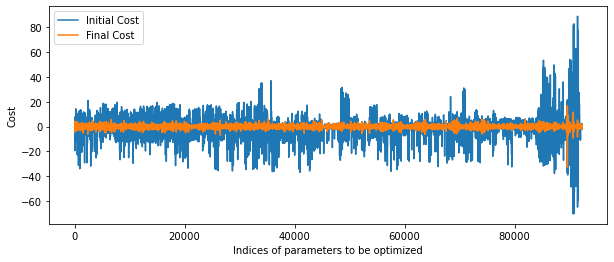

In [7]:
def reprojection_error(params: np.ndarray, num_cameras: int, num_points: int, camera_inds: np.ndarray, point_inds: np.ndarray, points_uv: np.ndarray) -> float:
    """Compute reprojection error: the difference between the observed 2D point and the 3D point projected and distorted onto the image plane"""

    camera_params = params[:num_cameras * 9].reshape((num_cameras, 9))
    points_xyz = params[num_cameras * 9:].reshape((num_points, 3))
    points_proj = project(points_xyz[point_inds], camera_params[camera_inds])

    # Reprojection error for each point observed by each camera (num_observations x 2)
    reproj_error = (points_proj - points_uv)

    mean_reproj_error = np.mean(np.linalg.norm(reproj_error, axis=1))
    return mean_reproj_error

# Results
initial_reproj_error = reprojection_error(x0, num_cameras, num_points, camera_inds, point_inds, points_uv)
final_reproj_error = reprojection_error(res.x, num_cameras, num_points, camera_inds, point_inds, points_uv)

print(f"Optimization took {round(t1 - t0, 2)} seconds")
print(f"Average initial reprojection error: {round(initial_reproj_error, 4)}")
print(f"Average final reprojection error: {round(final_reproj_error, 4)}")

# Plot results
plt.figure(figsize=(10,4))
plt.plot(f0, label="Initial Cost")  # inital cost
plt.plot(res.fun, label="Final Cost")  # final cost
plt.xlabel("Indices of parameters to be optimized")
plt.ylabel("Cost")
plt.legend()


Average initial reprojection error for camera 11 = 127.6858730491098
Average optimized reprojection error for camera 11 = 0.5366562360131455


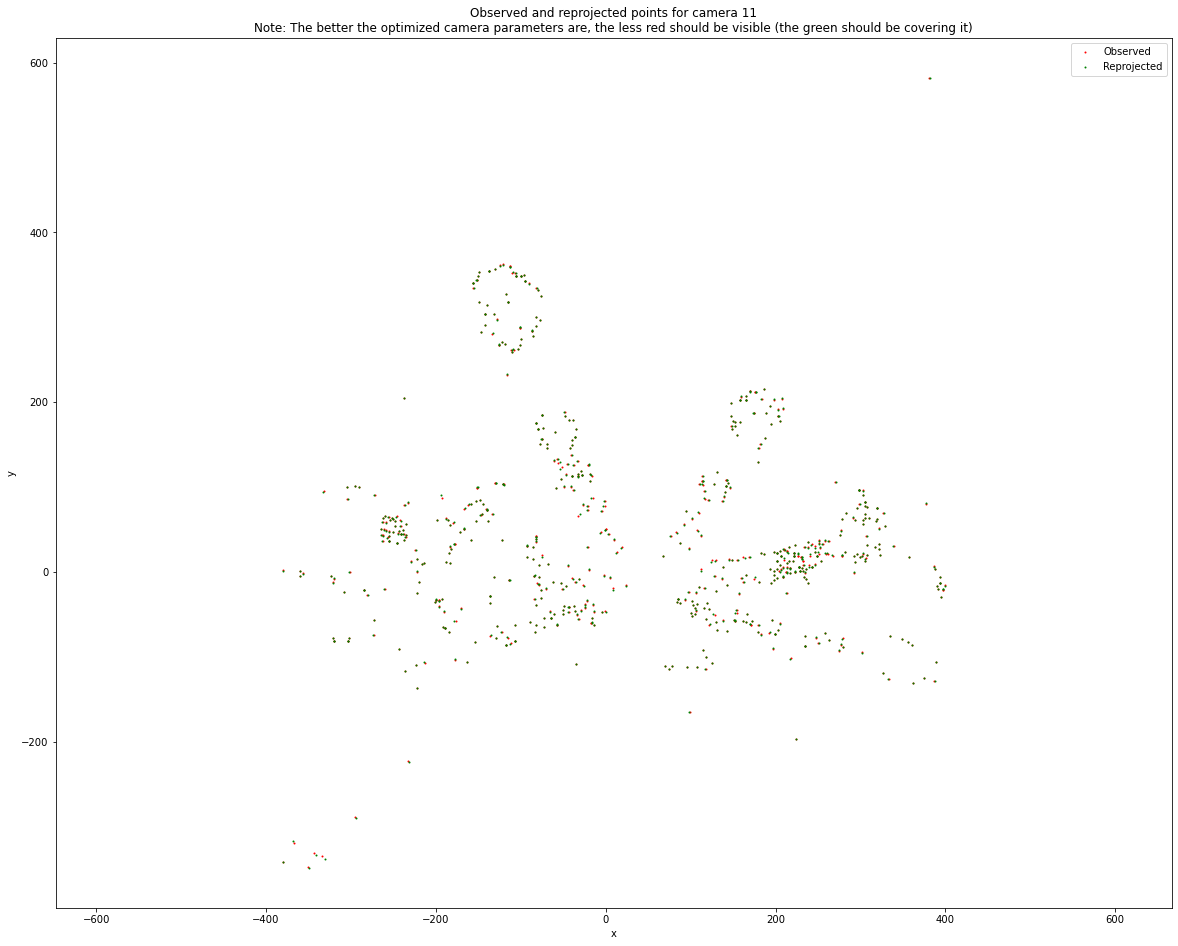

In [8]:
def plot_reprojected_points(camera_ind: int, camera_inds: np.ndarray, point_inds: np.ndarray, x0: np.ndarray, xf: np.ndarray, points_uv: np.ndarray, num_cameras: int, num_points: int) -> None:
    """Plot observed points and reprojected points for one camera. 
    This isn't a perfect representation, but gives a visual idea of 
    how far off the estimated points are from the observed."""

    # Identify the camera parameters associated with this camera
    single_camera_mask = (camera_inds == camera_ind)
    single_camera_point_inds = point_inds[single_camera_mask]

    single_camera_params_0 = x0[camera_ind * 9:(camera_ind + 1) * 9].reshape((1, 9))  # initial estimate of camera parameters
    single_camera_params = xf[camera_ind * 9:(camera_ind + 1) * 9].reshape((1, 9))  # optimized camera parameters

    # Identify the 2D points (uv) associated with this camera
    single_camera_points_uv = points_uv[single_camera_mask]

    # Identify the 3D points (xyz) associated with this camera
    all_points_xyz_0 = x0[num_cameras * 9:].reshape((num_points, 3))  # initial estimate of 3D point locations
    single_camera_points_xyz_0 = all_points_xyz_0[single_camera_point_inds]

    all_points_xyz = xf[num_cameras * 9:].reshape((num_points, 3))  # optimized 3D point locations
    single_camera_points_xyz = all_points_xyz[single_camera_point_inds]

    # Project points from 3D into 2D
    single_camera_points_proj_0 = project(single_camera_points_xyz_0, single_camera_params_0)
    single_camera_points_proj = project(single_camera_points_xyz, single_camera_params)

    # Calculate the reprojection error for this camera
    reproj_error_0 = (single_camera_points_proj_0 - single_camera_points_uv)  # reprojection error with initial estimates of camera parameters
    print(f"Average initial reprojection error for camera {camera_ind} = {np.mean(np.linalg.norm(reproj_error_0))}")

    reproj_error = (single_camera_points_proj - single_camera_points_uv)  # reprojection error with optimized camera parameters
    print(f"Average optimized reprojection error for camera {camera_ind} = {np.mean(np.linalg.norm(reproj_error, axis=1))}")

    # Plot the observed points and reprojected points for this camera
    plt.figure(figsize=(20, 16))
    plt.scatter(single_camera_points_uv[:,0], single_camera_points_uv[:,1], marker="o", s=1, color="r", label="Observed")
    # plt.scatter(single_camera_points_proj_0[:,0], single_camera_points_proj_0[:,1], marker="o", s=1, color="b", label="Initial Estimate")
    plt.scatter(single_camera_points_proj[:,0], single_camera_points_proj[:,1], marker="o", s=1, color="g", label="Reprojected")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.title(f"Observed and reprojected points for camera {camera_ind}\nNote: The better the optimized camera parameters are, the less red should be visible (the green should be covering it)")
    plt.legend()
    plt.show()

# Choose a random camera
camera_ind = np.random.choice(camera_inds)
plot_reprojected_points(camera_ind, camera_inds, point_inds, x0, res.x, points_uv, num_cameras, num_points)
